<a href="https://colab.research.google.com/github/Likitha-Thirumalasetty/Inventory-Demand-Forecasting/blob/main/Inventory_Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inventory Demand Forecasting**

Inventory demand forecasting is the process of predicting how much of a product or a service are the customers likely to buy in the future.

It is a key part of inventory and supply chain management and supply chain planning that ensures companies have the right amount of inventory to meet the customer demand

This also helps to reduce costs and improve customer service

The dataset contains 10 columns and 550,068 rows. Here's a quick overview of the columns:


User_ID: Unique identifier for each user.


Product_ID: Unique identifier for each product.


Gender: Gender of the user.


Age: Age group of the user.


Occupation: Numeric code for the user's occupation.


City_Category: Category of the city where the user resides.


Stay_In_Current_City_Years: Number of years the user has stayed in the current city.


Marital_Status: Marital status of the user (0 = Single, 1 = Married).


Product_Category: Numeric code for the product category.


Purchase: Purchase amount (in some monetary unit).

In [ ]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Load the dataset
file_path = '/content/walmart.csv'
data = pd.read_csv(file_path)

In [ ]:
# Data Cleaning
data['Stay_In_Current_City_Years'] = data['Stay_In_Current_City_Years'].replace('4+', 4).astype(int)

# Check for missing values
if data.isnull().sum().sum() > 0:
    data = data.dropna()

# Encoding categorical variables
categorical_columns = ['Gender', 'Age', 'City_Category']
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Selecting features and target variable
features = data_encoded.drop(columns=['User_ID', 'Product_ID', 'Purchase'])
target = data_encoded['Purchase']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

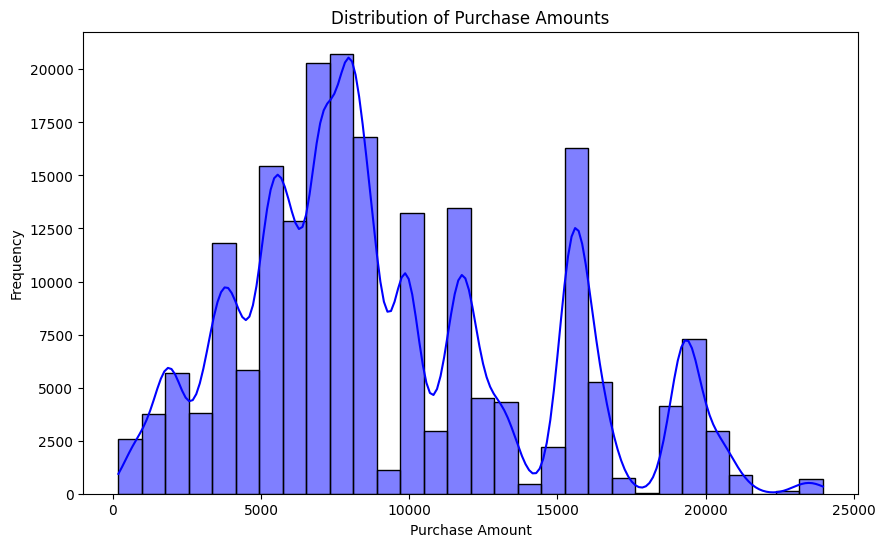

<ipython-input-4-33c0744be194>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_sales.index, y=product_sales.values, palette='viridis')


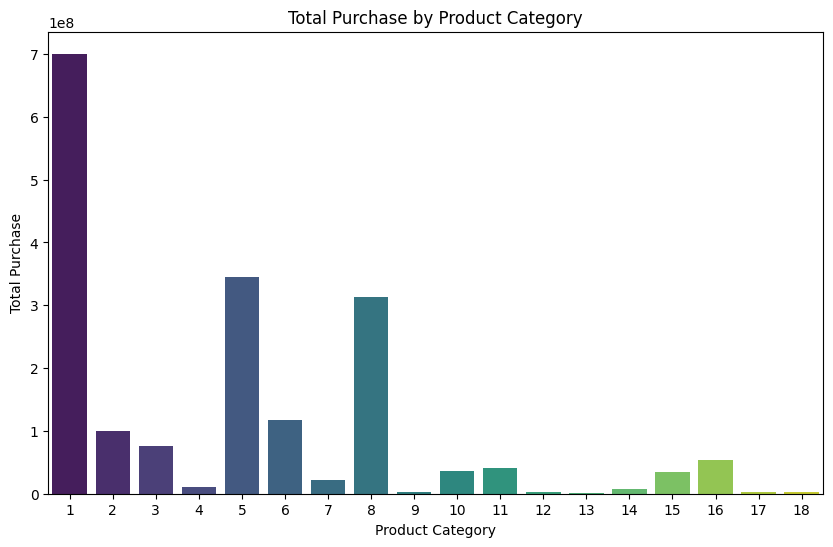

In [ ]:
# Visualizations
# Distribution of purchase amounts
plt.figure(figsize=(10, 6))
sns.histplot(data['Purchase'], kde=True, bins=30, color='blue')
plt.title('Distribution of Purchase Amounts')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')
plt.show()

# Total purchase by product category
plt.figure(figsize=(10, 6))
product_sales = data.groupby('Product_Category')['Purchase'].sum().sort_values(ascending=False)
sns.barplot(x=product_sales.index, y=product_sales.values, palette='viridis')
plt.title('Total Purchase by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Purchase')
plt.show()

In [ ]:
# Model Training
gbr_model = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
)
gbr_model.fit(X_train, y_train)

# Model Prediction
y_pred = gbr_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 8865172.604569294
R-squared: 0.6412057129507418


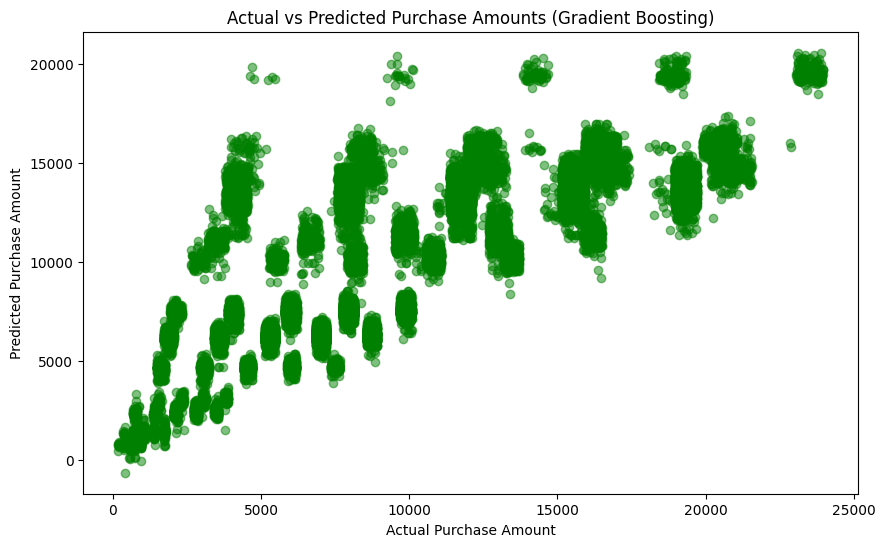

In [ ]:
# Visualizing Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='green')
plt.title('Actual vs Predicted Purchase Amounts (Gradient Boosting)')
plt.xlabel('Actual Purchase Amount')
plt.ylabel('Predicted Purchase Amount')
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

# Define the parameter grid with efficient ranges
param_dist = {
    'n_estimators': np.arange(100, 401, 100),  # 100 to 400, step of 100
    'learning_rate': np.linspace(0.01, 0.2, 5), # Linear space between 0.01 and 0.2
    'max_depth': np.arange(3, 11, 2),          # 3 to 10, step of 2
    'subsample': np.linspace(0.6, 1.0, 3),     # 0.6, 0.8, 1.0
    'min_samples_split': np.arange(2, 11, 3),  # 2, 5, 8
    'min_samples_leaf': np.arange(1, 5),       # 1 to 4
}

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=30,                     # Reduced iterations for faster search
    scoring='neg_mean_squared_error',
    cv=5,                         # 5-fold cross-validation for better generalization
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Display the best parameters
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 7, 'learning_rate': 0.105}


In [ ]:
# Get the best estimator from RandomizedSearchCV
best_gbr_model = random_search.best_estimator_

# Evaluate the optimized model
y_pred_optimized = best_gbr_model.predict(X_test)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f"Optimized Mean Squared Error: {mse_optimized}")
print(f"Optimized R-squared: {r2_optimized}")

Optimized Mean Squared Error: 8630438.390506657
Optimized R-squared: 0.650705956063579


In [ ]:
import pickle

# Save the best model
with open('optimized_gbr_model.pkl', 'wb') as f:
    pickle.dump(best_gbr_model, f)

# To load the model later
with open('optimized_gbr_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)